In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor

import dask

import python.climate_utils as cu
import python.utils as pu

import python.load_model_zone as plmz
import python.load_model_multizone as plm
from python.utils import project_path, zone_names, tgw_path

# Calculate temperature for load modeling

In [ ]:
############
### Dask ###
############
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers=20)

client = cluster.get_client()
client

In [ ]:
"""
Here we extract hourly zonal temperature data, which is needed
for the load model. We are working with the historical and future
TGW data, which is stored at `pu.tgw_path`. The hourly zonal temperatures
will be stored at `pu.project_path/data/climate/tgw`.
"""

# Required TGW variables
tgw_vars = ["T2C"]
tgw_var_str = tgw_vars[0]

# All TGW experiments
tgw_experiments = os.listdir(pu.tgw_path)

# Loop through all
for tgw_experiment in tgw_experiments:
    if os.path.isfile(
        f"{pu.project_path}/data/climate/tgw/zonal_{tgw_var_str}_{tgw_experiment}.csv"
    ):
        print(f"{tgw_experiment} already done")
        continue

    # Extract years
    tgw_experiment_yrs_str = tgw_experiment.split("_")[1:]
    tgw_years = np.arange(
        int(tgw_experiment_yrs_str[0]), int(tgw_experiment_yrs_str[1]) + 1
    )

    # Get paths of all hourly netcdf files
    tgw_paths = [
        glob(f"{pu.tgw_path}/{tgw_experiment}/hourly/*_{year}-*") for year in tgw_years
    ]
    tgw_paths = [path for sub_path in tgw_paths for path in sub_path]  # flatten

    # Parallelize with dask
    delayed = []

    for path in tgw_paths:
        delayed.append(dask.delayed(cu.tgw_to_zones)(path, tgw_vars))

    # Store
    df_out = pd.concat(dask.compute(*delayed))
    df_out.to_csv(
        f"{pu.project_path}/data/climate/tgw/zonal_{tgw_var_str}_{tgw_experiment}.csv"
    )
    print(tgw_experiment)

# Baseline load model

In [2]:
# Set up
climate_data = "tgw"
modelname = f"load_model_{climate_data}_multizone_NN"
modelpath = f"{project_path}/data/load/baseline/models/{modelname}.pkl"

## Model training

In [21]:
# Read predictors
climate_filenames = {"tgw": "zonal_T2C_historical_1980_2019"}
temp_data_path = (
    f"{project_path}/data/climate/{climate_data}/{climate_filenames[climate_data]}.csv"
)

# Read load data
load_data_path = (
    f"{project_path}/data/nyiso/historical_load/combined/historical_load.csv"
)

# Load data
temp_data, load_data = plm.load_and_prepare_data(temp_data_path, load_data_path)

### Exploratory analysis

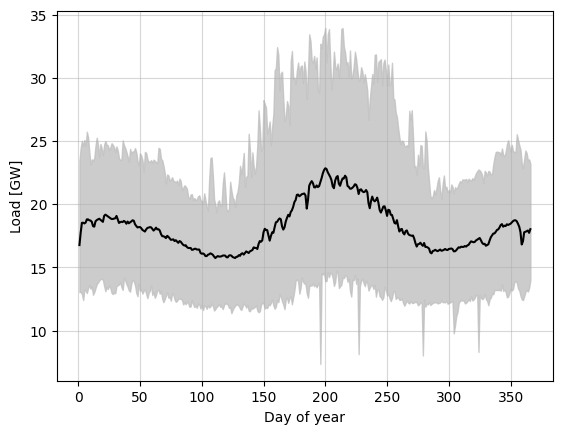

In [55]:
# Timeseries plot
load_data = load_data[load_data["load_MW"] > 0.0]
load_data_nyiso = load_data.groupby("time")[["load_MW"]].sum().reset_index()
load_data_nyiso["hourofyear"] = (
    load_data_nyiso["time"].dt.hour + (load_data_nyiso["time"].dt.dayofyear - 1) * 24
)
load_data_nyiso["dayofyear"] = load_data_nyiso["time"].dt.dayofyear
load_data_nyiso["load_GW"] = load_data_nyiso["load_MW"] / 1000

fig, ax = plt.subplots()

ax.fill_between(
    x=load_data_nyiso["dayofyear"].unique(),
    y1=load_data_nyiso.groupby("dayofyear")["load_GW"].min().to_numpy(),
    y2=load_data_nyiso.groupby("dayofyear")["load_GW"].max().to_numpy(),
    color="silver",
    alpha=0.8,
)

load_data_nyiso.groupby("dayofyear")["load_GW"].mean().plot(color="black")

ax.set_ylabel("Load [GW]")
ax.set_xlabel("Day of year")
ax.grid(alpha=0.5)
plt.show()

In [3]:
# Pivot
load_data_pivot = load_data.dropna().pivot(
    columns="zone", index="time", values="load_MW"
)

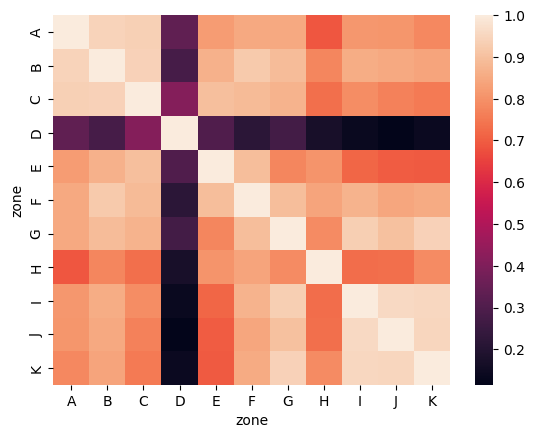

In [4]:
# There is significant correlation across zones that we
# want the model to capture!
fig, ax = plt.subplots()
sns.heatmap(load_data_pivot.corr(), ax=ax)
plt.show()

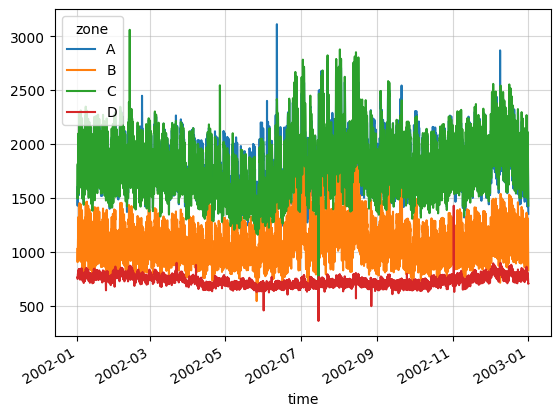

In [5]:
# Example timeseries
fig, ax = plt.subplots()
load_data_pivot[["A", "B", "C", "D"]].iloc[: 365 * 24].plot(ax=ax)
ax.grid(alpha=0.5)
plt.show()

### Fit the multi-zone model

In [6]:
# Create or load the multi-zone neural network model. This will train the model if it
# is not already stored at `modelpath`.
if not os.path.isfile(modelpath):
    # Specifiy model
    model = MLPRegressor(
        hidden_layer_sizes=(100, 100), early_stopping=True, max_iter=5000
    )

    # Initiate
    predictor = plm.MultiZoneLoadPredictor(model=model)

    # Train
    metrics = predictor.train(temp_data, load_data, test_split=[2016])

    # Save model
    predictor.save_model(modelpath)
else:
    # Load the model
    predictor = plm.MultiZoneLoadPredictor(model=None)
    predictor.load_model(modelpath)
    # Get the fit metrics
    metrics = predictor.results["metrics"]

Model saved to /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_multizone_NN.pkl


In [7]:
# Print evaluation metrics
for metric, value in metrics["overall"].items():
    print(f"{metric}: {value:.4f}")

rmse_train: 121.8249
mae_train: 64.1746
r2_train: 0.9190
rmse_test: 124.8111
mae_test: 63.7399
r2_test: 0.9185


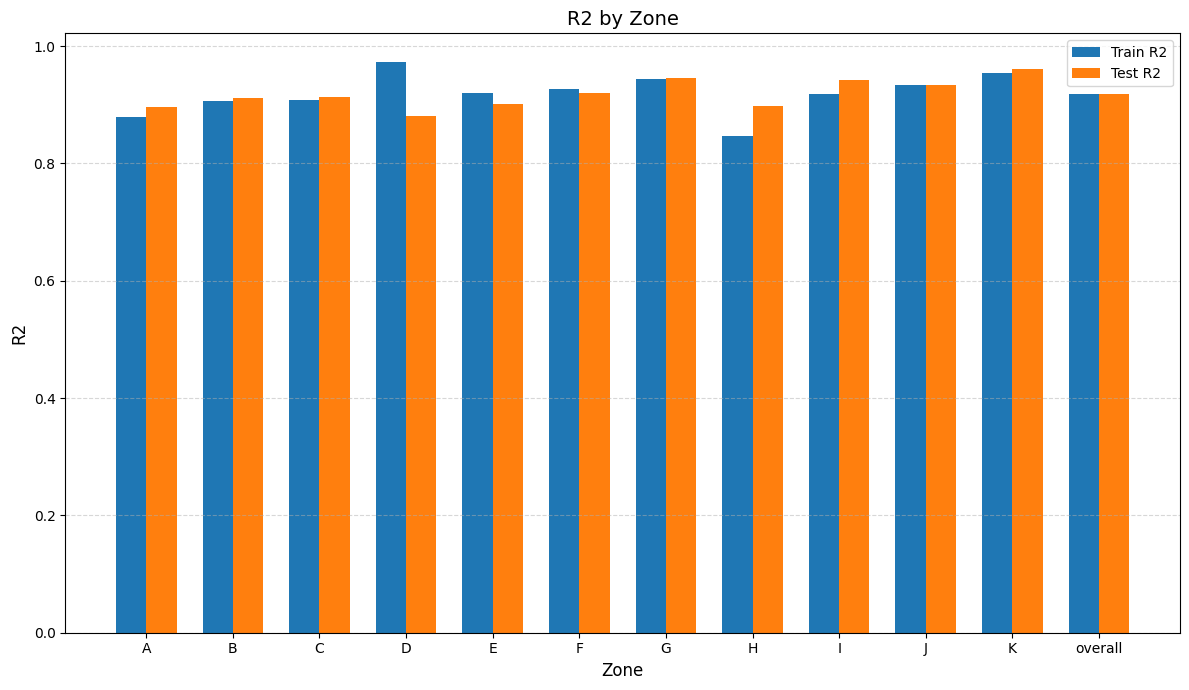

In [8]:
# Plot evaluation metrics by zone
metric_type = "r2"

# Extract zone names
zones = list(metrics.keys())

# Extract train and test values for the specified metric
train_values = [metrics[zone][f"{metric_type}_train"] for zone in zones]
test_values = [metrics[zone][f"{metric_type}_test"] for zone in zones]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set width of bars and positions
bar_width = 0.35
x = np.arange(len(zones))

# Create the grouped bars
train_bars = ax.bar(
    x - bar_width / 2, train_values, bar_width, label=f"Train {metric_type.upper()}"
)
test_bars = ax.bar(
    x + bar_width / 2, test_values, bar_width, label=f"Test {metric_type.upper()}"
)

# Set labels, title and legend
ax.set_xlabel("Zone", fontsize=12)
ax.set_ylabel(metric_type.upper(), fontsize=12)
ax.set_title(f"{metric_type.upper()} by Zone", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(zones)
ax.legend()

# Add a grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Adjust layout
plt.tight_layout()

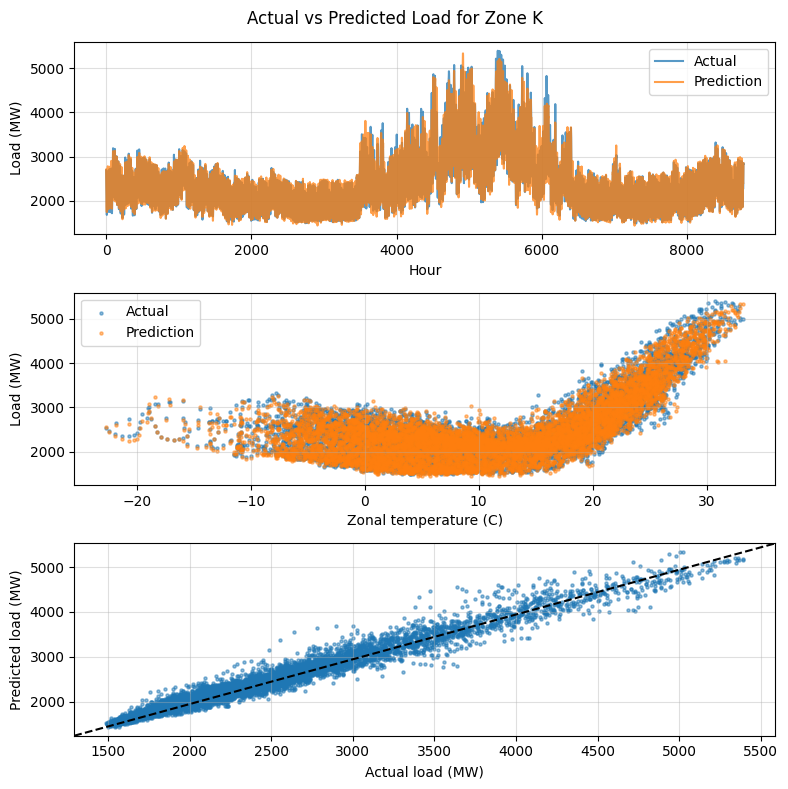

In [9]:
# Show results for given zone
predictor.plot_results("K")

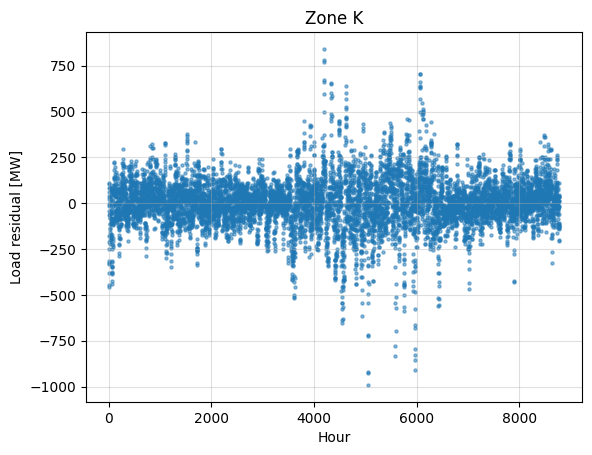

In [10]:
# Check residuals for given zone
zone = "K"
zone_idx = predictor.zones.index(zone)

fig, ax = plt.subplots()

residuals = (
    predictor.results["y_true_test"][:, zone_idx]
    - predictor.results["y_pred_test"][:, zone_idx]
)
residuals = residuals[predictor.results["y_true_test"][:, zone_idx] > 0]

ax.scatter(x=np.arange(len(residuals)), y=residuals, s=5, alpha=0.5)

ax.set_title(f"Zone {zone}")
ax.set_xlabel("Hour")
ax.set_ylabel("Load residual [MW]")
ax.grid(alpha=0.4)
plt.show()

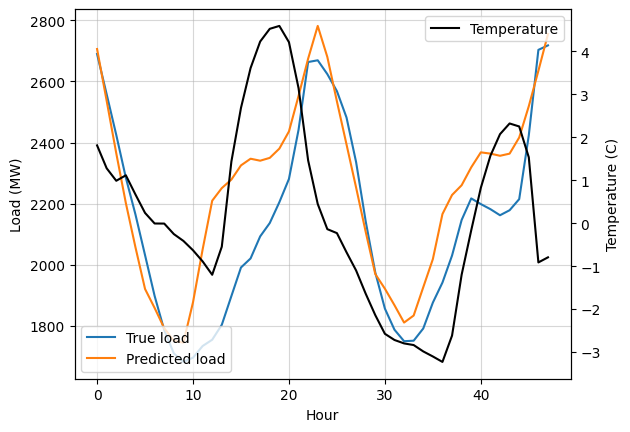

In [11]:
# Timeseries plot: winter
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax.plot(predictor.results["y_true_test"][:48, zone_idx], label="True load")
ax.plot(predictor.results["y_pred_test"][:48, zone_idx], label="Predicted load")
ax.set_xlabel("Hour")
ax.grid(alpha=0.5)
ax.set_ylabel("Load (MW)")
ax.legend(loc="lower left")

ax1.plot(
    predictor.results["test_temps"][:48, zone_idx], color="black", label="Temperature"
)
ax1.legend()
ax1.set_ylabel("Temperature (C)")

plt.show()

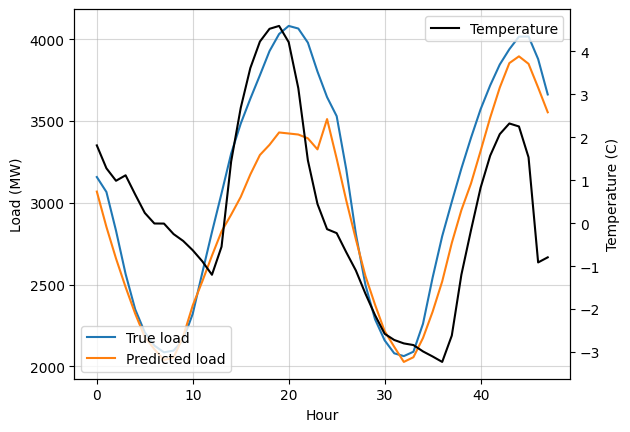

In [12]:
# Timeseries plot: summer
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax.plot(
    predictor.results["y_true_test"][180 * 24 : 180 * 24 + 48, zone_idx],
    label="True load",
)
ax.plot(
    predictor.results["y_pred_test"][180 * 24 : 180 * 24 + 48, zone_idx],
    label="Predicted load",
)
ax.set_xlabel("Hour")
ax.grid(alpha=0.5)
ax.set_ylabel("Load (MW)")
ax.legend(loc="lower left")

ax1.plot(
    predictor.results["test_temps"][:48, zone_idx], color="black", label="Temperature"
)
ax1.legend()
ax1.set_ylabel("Temperature (C)")

plt.show()

## Generating new timeseries

In [3]:
# Load the model
predictor = plm.MultiZoneLoadPredictor(model=None)
predictor.load_model(modelpath)

Model loaded from /home/fs01/dcl257/projects/acorn-julia/data/load/baseline/models/load_model_tgw_multizone_NN.pkl


In [4]:
# New climate input data
tgw_var_str = "T2C"
tgw_experiments = np.sort(os.listdir(tgw_path))

# Loop through all
for tgw_experiment in tgw_experiments[:2]:
    # Check if done
    store_path = f"{project_path}/data/load/baseline/simulated/{modelname}_{tgw_experiment}.parquet"
    if os.path.exists(store_path):
        continue

    # Temperature data path
    temp_data_path = (
        f"{project_path}/data/climate/tgw/zonal_{tgw_var_str}_{tgw_experiment}.csv"
    )
    # Get bus-level load
    df_bus_load = plm.baseline_load_to_bus(predictor, temp_data_path)
    # Store
    df_bus_load.to_parquet(store_path, index=False)

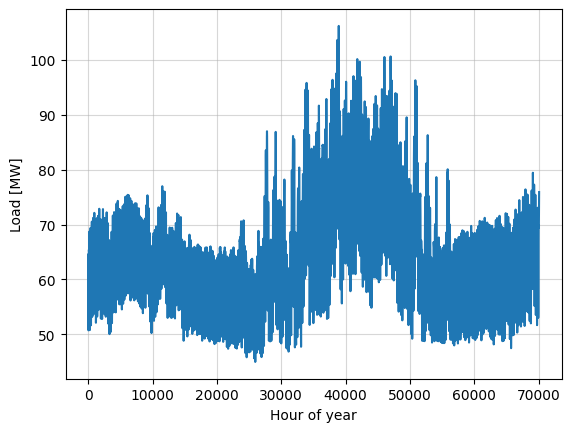

In [11]:
# Check a single bus
fig, ax = plt.subplots()
df_bus_load.query("bus_id == 58")["load_MW"][:8760].plot(ax=ax)
ax.set_xlabel("Hour of year")
ax.set_ylabel("Load [MW]")
ax.grid(alpha=0.5)
plt.show()

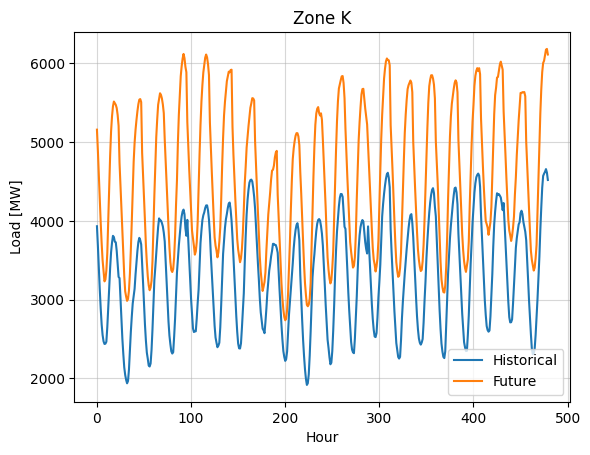

In [33]:
# Check a zone compared to historical
zone = "K"
zone_idx = predictor.zones.index(zone)

df_zonal_load_hist = pd.DataFrame(
    {
        "datetime": predictor.results["train_datetimes"],
        "y_pred": predictor.results["y_pred_train"][:, zone_idx],
    }
)
df_zonal_load_fut = df_bus_load[df_bus_load["zone"] == zone].drop_duplicates(
    ["datetime", "zone"]
)

# Need to align years for TGW
df_zonal_load_hist = df_zonal_load_hist[df_zonal_load_hist["datetime"].dt.year == 2019]
df_zonal_load_fut = df_zonal_load_fut[df_zonal_load_fut["datetime"].dt.year == 2099]

fig, ax = plt.subplots()

id_start = 180 * 24
id_end = 200 * 24

ax.plot(
    df_zonal_load_hist.iloc[id_start:id_end]["y_pred"].to_numpy(), label="Historical"
)
ax.plot(
    df_zonal_load_fut.iloc[id_start:id_end]["zonal_load_MW"].to_numpy(), label="Future"
)
ax.legend()
ax.set_ylabel("Load [MW]")
ax.set_xlabel("Hour")
ax.set_title(f"Zone {zone}")

ax.grid(alpha=0.5)
plt.show()

## Zonal models (old!)

In [20]:
# Create a load predictor
zonal_predictor = plmz.LoadPredictor()  # Default: RandomForestRegressor

# from sklearn.neural_network import MLPRegressor
# predictor = plm.LoadPredictor(model=MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42))

In [32]:
# # Loop through all
# for zone in zone_names:
#     print(f"Now modeling: {zone}")
#     # Train
#     model = predictor.train(temp_data, load_data, zone, test_split=[2016])
#     # Show results
#     filepath = f"{project_path}/figs/load_model_{climate_data}_zone{zone}.pdf"
#     predictor.plot_results(zone, filepath=filepath)
#     # Save model
#     filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
#     predictor.save_model(zone, filepath=filepath)

In [22]:
# for zone in zone_names:
#     filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
#     zonal_predictor.load_model(zone, filepath = filepath)

In [49]:
print("\nBy Zone:")
for zone in predictor.zone_columns:
    print(f"\nZone {zone}:")
    for metric in ["train_r2", "test_r2"]:
        print(f"  {metric}: {zonal_predictor.zone_models[zone]['metrics'][metric]}")


By Zone:

Zone A:
  train_r2: 0.9356197600237405
  test_r2: 0.431593111331694

Zone B:
  train_r2: 0.9295739117642258
  test_r2: 0.45974918836319134

Zone C:
  train_r2: 0.9324817220362195
  test_r2: 0.3937280588686408

Zone D:
  train_r2: 0.9938219556882089
  test_r2: 0.6636331897861913

Zone E:
  train_r2: 0.9393521680304869
  test_r2: 0.36277739637509

Zone F:
  train_r2: 0.9349472362452553
  test_r2: 0.44170775430665665

Zone G:
  train_r2: 0.940633839340587
  test_r2: 0.5523183452347395

Zone H:
  train_r2: 0.9499927733265421
  test_r2: 0.45034343764516793

Zone I:
  train_r2: 0.9462769990924754
  test_r2: 0.5875547898860385

Zone J:
  train_r2: 0.9389805910633277
  test_r2: 0.5800722893396236

Zone K:
  train_r2: 0.9541427993396298
  test_r2: 0.6789042237906777


In [34]:
# Gather all predictions
df_pred = []
for zone in zone_names:
    df_pred.append(
        zonal_predictor.zone_models[zone]["test_results"]
        .set_index("datetime")[["y_pred"]]
        .rename(columns={"y_pred": zone})
    )

df_pred = pd.concat(df_pred, axis=1)

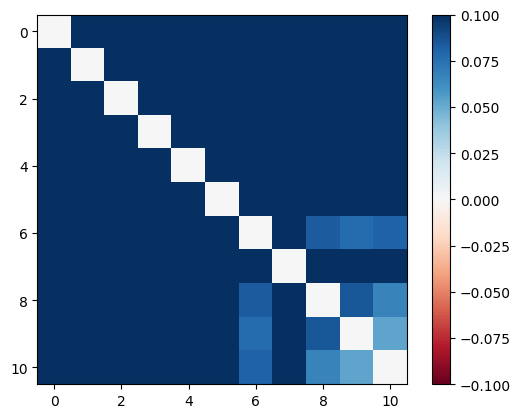

In [43]:
# Check correlational differences
load_data_pivot = load_data[load_data["time"].dt.year == 2016].pivot(
    index="time", columns="zone"
)

fig, ax = plt.subplots()
image = ax.imshow(
    load_data_pivot.corr().to_numpy() - df_pred.corr().to_numpy(),
    vmin=-0.1,
    vmax=0.1,
    cmap="RdBu",
)
plt.colorbar(image)
plt.show()